# Hardware Accelerator Benchmark

**Module:** MOD002691 - Computing Project  
**Project:** SnapShelf - Food Image Classification  
**Author:** Oriol Morros Vilaseca  
**Supervisor:** Mr Vitaliy Milke

---

## 1. Introduction

This notebook evaluates hardware accelerators available in Google Colab Pro to determine the optimal training environment for the SnapShelf model comparison study. A controlled benchmark ensures consistent hardware selection across all subsequent experiments.

### 1.1 Accelerators Evaluated

| Accelerator | Type | Relative Cost |
|-------------|------|---------------|
| CPU (baseline) | CPU | 0.5x |
| Tesla T4 | GPU | 1.0x |
| NVIDIA L4 | GPU | 2.0x |
| NVIDIA A100 | GPU | 4.0x |

### 1.2 Experimental Controls

All benchmarks use identical conditions:
- Model: Custom CNN architecture (26M parameters)
- Dataset: SnapShelf 14-class food dataset (84,582 training images)
- Image size: 224x224 pixels
- Batch size: 32
- Epochs: 3
- Random seed: 42

---
## 2. Environment Setup

In [1]:
# Mount Google Drive and configure directory structure

from google.colab import drive
drive.mount('/content/drive')

import os

# Directory structure
BASE_DIR = '/content/drive/MyDrive/snapshelf_models_v3'
BENCHMARK_DIR = os.path.join(BASE_DIR, 'benchmark')
MODELS_DIR = os.path.join(BASE_DIR, 'models')
HISTORY_DIR = os.path.join(BASE_DIR, 'training_history')
EVALUATION_DIR = os.path.join(BASE_DIR, 'evaluation')
COMPARISON_DIR = os.path.join(BASE_DIR, 'comparison')

for directory in [BASE_DIR, BENCHMARK_DIR, MODELS_DIR, HISTORY_DIR, EVALUATION_DIR, COMPARISON_DIR]:
    os.makedirs(directory, exist_ok=True)

RESULTS_CSV = os.path.join(BENCHMARK_DIR, 'accelerator_benchmark.csv')
print(f"Results path: {RESULTS_CSV}")

Mounted at /content/drive
Results path: /content/drive/MyDrive/snapshelf_models_v3/benchmark/accelerator_benchmark.csv


In [2]:
# Detect current hardware accelerator

import subprocess

def detect_accelerator():
    """Detect the active hardware accelerator."""
    # Check for GPU
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=name', '--format=csv,noheader'],
            capture_output=True, text=True, timeout=10
        )
        if result.returncode == 0 and result.stdout.strip():
            return result.stdout.strip(), "GPU"
    except (FileNotFoundError, subprocess.TimeoutExpired):
        pass
    return "CPU", "CPU"

ACCELERATOR_NAME, ACCELERATOR_TYPE = detect_accelerator()
print(f"Accelerator: {ACCELERATOR_NAME}")
print(f"Type: {ACCELERATOR_TYPE}")

Accelerator: Tesla T4
Type: GPU


In [3]:
# Import dependencies

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import time
import csv
import threading
from datetime import datetime

print(f"TensorFlow: {tf.__version__}")

# Configure GPU memory growth if applicable
if ACCELERATOR_TYPE == "GPU":
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPUs configured: {len(gpus)}")

TensorFlow: 2.19.0
GPUs configured: 1


---
## 3. Benchmark Configuration

In [4]:
# Define benchmark parameters

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

BENCHMARK_EPOCHS = 3
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Dataset paths
DATASET_ZIP = '/content/drive/MyDrive/snapshelf_final_dataset/snapshelf_dataset_14classes_deduped.zip'
LOCAL_DATASET = '/content/snapshelf_dataset'
TRAIN_DIR = f"{LOCAL_DATASET}/train"
VAL_DIR = f"{LOCAL_DATASET}/val"

# Cost tiers relative to T4 baseline (based on Colab Pro compute unit rates)
COST_TIERS = {
    'CPU': 0.5,
    'Tesla T4': 1.0,
    'NVIDIA T4': 1.0,
    'NVIDIA L4': 2.0,
    'NVIDIA A100-SXM4-40GB': 4.0,
    'NVIDIA A100-SXM4-80GB': 4.0,
    'NVIDIA A100': 4.0,
}

def get_cost_tier(name):
    """Return relative cost tier for an accelerator."""
    for key in COST_TIERS:
        if key in name:
            return COST_TIERS[key]
    return 1.0

COST_TIER = get_cost_tier(ACCELERATOR_NAME)

print(f"Seed: {SEED}")
print(f"Epochs: {BENCHMARK_EPOCHS}")
print(f"Image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Cost tier: {COST_TIER}x")

Seed: 42
Epochs: 3
Image size: (224, 224)
Batch size: 32
Cost tier: 1.0x


In [5]:
# Extract dataset

import zipfile
import shutil

if not os.path.exists(DATASET_ZIP):
    raise FileNotFoundError(f"Dataset not found: {DATASET_ZIP}")

if os.path.exists(LOCAL_DATASET):
    shutil.rmtree(LOCAL_DATASET)

with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
    zip_ref.extractall(LOCAL_DATASET)

n_train = len([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
n_val = len([d for d in os.listdir(VAL_DIR) if os.path.isdir(os.path.join(VAL_DIR, d))])
print(f"Train classes: {n_train}")
print(f"Validation classes: {n_val}")

Train classes: 14
Validation classes: 14


In [6]:
# Create data generators

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

NUM_CLASSES = len(train_generator.class_indices)
print(f"Classes: {NUM_CLASSES}")
print(f"Training samples: {train_generator.samples:,}")
print(f"Validation samples: {val_generator.samples:,}")

Found 84582 images belonging to 14 classes.
Found 18119 images belonging to 14 classes.
Classes: 14
Training samples: 84,582
Validation samples: 18,119


---
## 4. Model Architecture

In [7]:
# Define Custom CNN architecture

def build_benchmark_cnn(input_shape=(224, 224, 3), num_classes=14):
    """Build the Custom CNN used for benchmarking."""
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

benchmark_model = build_benchmark_cnn(num_classes=NUM_CLASSES)
benchmark_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         7,182 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,086,222 (99.51 MB)

 Trainable params: 26,086,222 (99.51 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# GPU monitoring utility

class GPUMonitor:
    """Monitor GPU memory and utilisation during training."""

    def __init__(self, accelerator_type):
        self.accelerator_type = accelerator_type
        self.monitoring = False
        self.memory_samples = []
        self.utilisation_samples = []
        self.monitor_thread = None

    def _sample_gpu_stats(self):
        """Sample GPU statistics at 0.5s intervals."""
        while self.monitoring:
            try:
                mem_result = subprocess.run(
                    ['nvidia-smi', '--query-gpu=memory.used', '--format=csv,noheader,nounits'],
                    capture_output=True, text=True, timeout=5
                )
                if mem_result.returncode == 0:
                    self.memory_samples.append(float(mem_result.stdout.strip()))

                util_result = subprocess.run(
                    ['nvidia-smi', '--query-gpu=utilization.gpu', '--format=csv,noheader,nounits'],
                    capture_output=True, text=True, timeout=5
                )
                if util_result.returncode == 0:
                    self.utilisation_samples.append(float(util_result.stdout.strip()))
            except:
                pass
            time.sleep(0.5)

    def start(self):
        """Start GPU monitoring."""
        if self.accelerator_type != "GPU":
            return
        self.monitoring = True
        self.memory_samples = []
        self.utilisation_samples = []
        self.monitor_thread = threading.Thread(target=self._sample_gpu_stats, daemon=True)
        self.monitor_thread.start()

    def stop(self):
        """Stop GPU monitoring."""
        self.monitoring = False
        if self.monitor_thread:
            self.monitor_thread.join(timeout=2)

    def get_results(self):
        """Return collected metrics."""
        if self.accelerator_type != "GPU" or not self.memory_samples:
            return {'peak_memory_mb': 'N/A', 'avg_memory_mb': 'N/A', 'avg_utilisation_pct': 'N/A'}
        return {
            'peak_memory_mb': round(max(self.memory_samples), 1),
            'avg_memory_mb': round(np.mean(self.memory_samples), 1),
            'avg_utilisation_pct': round(np.mean(self.utilisation_samples), 1) if self.utilisation_samples else 'N/A'
        }

print(f"GPU monitoring available: {ACCELERATOR_TYPE == 'GPU'}")

GPU monitoring available: True


---
## 5. Execute Benchmark

In [9]:
# Run benchmark training

print(f"Accelerator: {ACCELERATOR_NAME}")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("-" * 50)

train_steps = train_generator.samples // BATCH_SIZE
val_steps = val_generator.samples // BATCH_SIZE

train_generator.reset()
val_generator.reset()

gpu_monitor = GPUMonitor(ACCELERATOR_TYPE)

class TimeCallback(tf.keras.callbacks.Callback):
    """Track per-epoch training time."""
    def __init__(self):
        self.epoch_times = []
        self.epoch_start = None

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.epoch_start
        self.epoch_times.append(elapsed)
        print(f"Epoch {epoch + 1}: {elapsed:.2f}s | loss: {logs['loss']:.4f} | acc: {logs['accuracy']:.4f}")

time_callback = TimeCallback()

gpu_monitor.start()
start_time = time.time()

try:
    history = benchmark_model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=BENCHMARK_EPOCHS,
        validation_data=val_generator,
        validation_steps=val_steps,
        callbacks=[time_callback],
        verbose=1
    )
    training_status = "Success"
except Exception as e:
    training_status = f"Error: {str(e)[:50]}"
    print(f"Training failed: {e}")
    history = None

end_time = time.time()
gpu_monitor.stop()

total_time = end_time - start_time
avg_epoch_time = np.mean(time_callback.epoch_times) if time_callback.epoch_times else 0
gpu_results = gpu_monitor.get_results()

print("-" * 50)
print(f"Total time: {total_time:.2f}s")
print(f"Avg epoch time: {avg_epoch_time:.2f}s")
print(f"Peak memory: {gpu_results['peak_memory_mb']}")
print(f"Avg utilisation: {gpu_results['avg_utilisation_pct']}")

Accelerator: Tesla T4
Timestamp: 2026-01-29 16:35:27
--------------------------------------------------
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2643/2643 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8370 - loss: 0.4924

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1: 236.83s | loss: 0.2348 | acc: 0.9187
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 237s 86ms/step - accuracy: 0.8370 - loss: 0.4923 - val_accuracy: 0.9730 - val_loss: 0.0681
Epoch 2/3
   1/2643 ━━━━━━━━━━━━━━━━━━━━ 3:40 83ms/step - accuracy: 0.9375 - loss: 0.2055

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 2: 27.32s | loss: 0.2055 | acc: 0.9375
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.9375 - loss: 0.2055 - val_accuracy: 0.9725 - val_loss: 0.0697
Epoch 3/3
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9682 - loss: 0.0851Epoch 3: 209.11s | loss: 0.0866 | acc: 0.9683
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 209s 79ms/step - accuracy: 0.9682 - loss: 0.0851 - val_accuracy: 0.9679 - val_loss: 0.0977
--------------------------------------------------
Total time: 473.50s
Avg epoch time: 157.75s
Peak memory: 2174.0
Avg utilisation: 67.4


In [22]:
# Log results to CSV

result = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'accelerator_name': ACCELERATOR_NAME,
    'accelerator_type': ACCELERATOR_TYPE,
    'total_time_seconds': round(total_time, 2),
    'avg_epoch_time_seconds': round(avg_epoch_time, 2),
    'epochs_run': BENCHMARK_EPOCHS,
    'peak_memory_mb': gpu_results['peak_memory_mb'],
    'avg_memory_mb': gpu_results['avg_memory_mb'],
    'avg_utilisation_pct': gpu_results['avg_utilisation_pct'],
    'cost_tier': COST_TIER,
    'final_train_accuracy': round(history.history['accuracy'][-1], 4) if history else 'N/A',
    'final_val_accuracy': round(history.history['val_accuracy'][-1], 4) if history else 'N/A',
    'status': training_status
}

fieldnames = [
    'timestamp', 'accelerator_name', 'accelerator_type', 'total_time_seconds',
    'avg_epoch_time_seconds', 'epochs_run', 'peak_memory_mb', 'avg_memory_mb',
    'avg_utilisation_pct', 'cost_tier', 'final_train_accuracy', 'final_val_accuracy', 'status'
]

file_exists = os.path.isfile(RESULTS_CSV)
with open(RESULTS_CSV, 'a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if not file_exists:
        writer.writeheader()
    writer.writerow(result)

print(f"Results saved to: {RESULTS_CSV}")
for key, value in result.items():
    print(f"  {key}: {value}")

Results saved to: /content/drive/MyDrive/snapshelf_models_v3/benchmark/accelerator_benchmark.csv
  timestamp: 2026-01-29 16:56:29
  accelerator_name: Tesla T4
  accelerator_type: GPU
  total_time_seconds: 473.5
  avg_epoch_time_seconds: 157.75
  epochs_run: 3
  peak_memory_mb: 2174.0
  avg_memory_mb: 2158.7
  avg_utilisation_pct: 67.4
  cost_tier: 1.0
  final_train_accuracy: 0.9683
  final_val_accuracy: 0.9679
  status: Success


---
## 6. Results Analysis

Execute this section after completing benchmarks on all accelerators.

In [25]:
# Load benchmark results

import pandas as pd

results_df = pd.read_csv(RESULTS_CSV)
print(f"Benchmark runs: {len(results_df)}")
print(f"Accelerators: {results_df['accelerator_name'].nunique()}")
print()
print(results_df.to_string(index=False))

Benchmark runs: 4
Accelerators: 4

          timestamp      accelerator_name accelerator_type  total_time_seconds  avg_epoch_time_seconds  epochs_run  peak_memory_mb  avg_memory_mb  avg_utilisation_pct  cost_tier  final_train_accuracy  final_val_accuracy  status
2026-01-29 11:26:39              Tesla T4              GPU              480.05                  159.96           3          2174.0         2174.0                 65.8        1.0                0.9658              0.9743 Success
2026-01-29 11:36:37             NVIDIA L4              GPU              345.54                  115.12           3          2263.0         2242.0                 66.5        2.0                0.9654              0.9695 Success
2026-01-29 11:44:36 NVIDIA A100-SXM4-80GB              GPU              340.79                  113.53           3          4549.0         3671.4                 18.1        4.0                0.9676              0.9724 Success
2026-01-29 15:30:20                   CPU            

In [26]:
# Performance comparison table

print("PERFORMANCE COMPARISON")
print("=" * 70)

analysis_df = results_df[['accelerator_name', 'accelerator_type', 'avg_epoch_time_seconds',
                          'total_time_seconds', 'cost_tier', 'status']].copy()

# Calculate speedup relative to slowest (CPU baseline)
baseline_time = analysis_df['avg_epoch_time_seconds'].max()
analysis_df['speedup'] = round(baseline_time / analysis_df['avg_epoch_time_seconds'], 2)
analysis_df['cost_efficiency'] = round(analysis_df['speedup'] / analysis_df['cost_tier'], 2)

analysis_df = analysis_df.sort_values('avg_epoch_time_seconds')
print(analysis_df.to_string(index=False))
print()
print("Speedup: relative to CPU baseline")
print("Cost efficiency: speedup / cost_tier (higher is better)")

PERFORMANCE COMPARISON
     accelerator_name accelerator_type  avg_epoch_time_seconds  total_time_seconds  cost_tier  status  speedup  cost_efficiency
NVIDIA A100-SXM4-80GB              GPU                  113.53              340.79        4.0 Success    20.95             5.24
            NVIDIA L4              GPU                  115.12              345.54        2.0 Success    20.66            10.33
             Tesla T4              GPU                  159.96              480.05        1.0 Success    14.87            14.87
                  CPU              CPU                 2378.93             7137.04        0.5 Success     1.00             2.00

Speedup: relative to CPU baseline
Cost efficiency: speedup / cost_tier (higher is better)


In [27]:
# GPU-specific metrics

print("GPU MEMORY AND UTILISATION")
print("=" * 70)

gpu_df = results_df[results_df['accelerator_type'] == 'GPU'].copy()

if len(gpu_df) > 0:
    gpu_metrics = gpu_df[['accelerator_name', 'avg_epoch_time_seconds',
                          'peak_memory_mb', 'avg_memory_mb', 'avg_utilisation_pct']].copy()
    gpu_metrics = gpu_metrics.sort_values('avg_epoch_time_seconds')
    print(gpu_metrics.to_string(index=False))
else:
    print("No GPU results available.")

GPU MEMORY AND UTILISATION
     accelerator_name  avg_epoch_time_seconds  peak_memory_mb  avg_memory_mb  avg_utilisation_pct
NVIDIA A100-SXM4-80GB                  113.53          4549.0         3671.4                 18.1
            NVIDIA L4                  115.12          2263.0         2242.0                 66.5
             Tesla T4                  159.96          2174.0         2174.0                 65.8


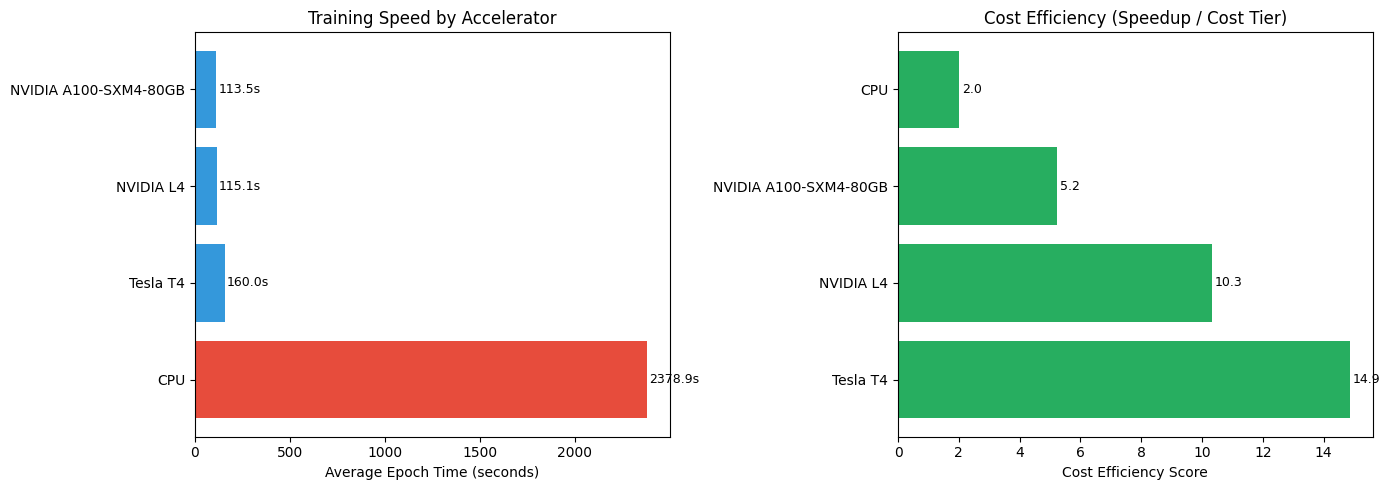

Figure saved: /content/drive/MyDrive/snapshelf_models_v3/benchmark/accelerator_comparison.png


In [28]:
# Visualisation: Training time comparison

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Average epoch time
sorted_df = results_df.sort_values('avg_epoch_time_seconds')
colors = ['#E74C3C' if t == 'CPU' else '#3498DB' for t in sorted_df['accelerator_type']]

bars1 = axes[0].barh(sorted_df['accelerator_name'], sorted_df['avg_epoch_time_seconds'], color=colors)
axes[0].set_xlabel('Average Epoch Time (seconds)')
axes[0].set_title('Training Speed by Accelerator')
axes[0].invert_yaxis()

for bar, val in zip(bars1, sorted_df['avg_epoch_time_seconds']):
    axes[0].text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2, f'{val:.1f}s', va='center', fontsize=9)

# Plot 2: Cost efficiency
efficiency_df = analysis_df.sort_values('cost_efficiency', ascending=True)
bars2 = axes[1].barh(efficiency_df['accelerator_name'], efficiency_df['cost_efficiency'], color='#27AE60')
axes[1].set_xlabel('Cost Efficiency Score')
axes[1].set_title('Cost Efficiency (Speedup / Cost Tier)')
axes[1].invert_yaxis()

for bar, val in zip(bars2, efficiency_df['cost_efficiency']):
    axes[1].text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{val:.1f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(BENCHMARK_DIR, 'accelerator_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Figure saved: {os.path.join(BENCHMARK_DIR, 'accelerator_comparison.png')}")

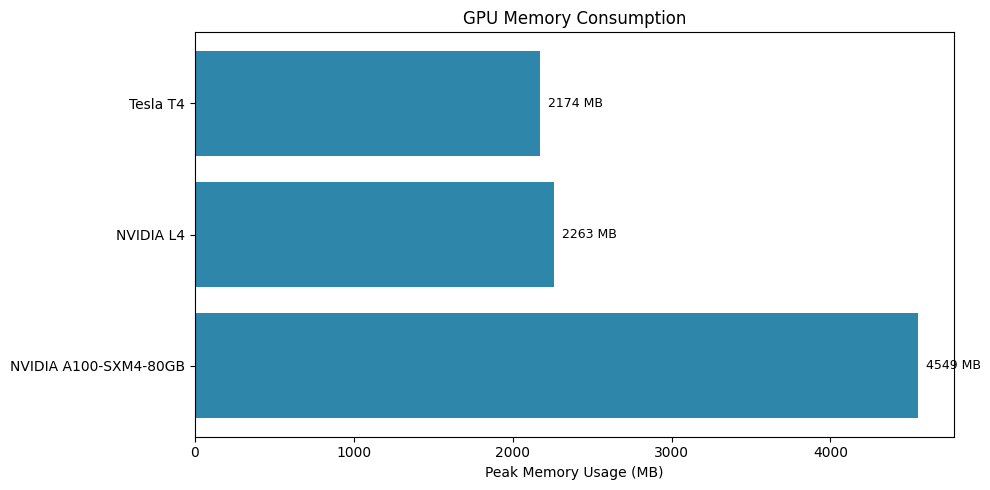

Figure saved: /content/drive/MyDrive/snapshelf_models_v3/benchmark/gpu_memory_comparison.png


In [29]:
# GPU memory comparison

gpu_df = results_df[results_df['accelerator_type'] == 'GPU'].copy()

if len(gpu_df) > 0:
    gpu_df['peak_memory_mb'] = pd.to_numeric(gpu_df['peak_memory_mb'], errors='coerce')
    gpu_df = gpu_df.dropna(subset=['peak_memory_mb'])

    if len(gpu_df) > 0:
        fig, ax = plt.subplots(figsize=(10, 5))
        gpu_df = gpu_df.sort_values('peak_memory_mb')

        bars = ax.barh(gpu_df['accelerator_name'], gpu_df['peak_memory_mb'], color='#2E86AB')
        ax.set_xlabel('Peak Memory Usage (MB)')
        ax.set_title('GPU Memory Consumption')
        ax.invert_yaxis()

        for bar, val in zip(bars, gpu_df['peak_memory_mb']):
            ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, f'{val:.0f} MB', va='center', fontsize=9)

        plt.tight_layout()
        plt.savefig(os.path.join(BENCHMARK_DIR, 'gpu_memory_comparison.png'), dpi=150, bbox_inches='tight')
        plt.show()

        print(f"Figure saved: {os.path.join(BENCHMARK_DIR, 'gpu_memory_comparison.png')}")

---
## 7. Conclusion and Recommendation

In [30]:
# Generate recommendation

print("BENCHMARK SUMMARY")
print("=" * 70)

analysis_df = results_df.copy()
analysis_df['avg_epoch_time_seconds'] = pd.to_numeric(analysis_df['avg_epoch_time_seconds'])
analysis_df['cost_tier'] = pd.to_numeric(analysis_df['cost_tier'])

baseline_time = analysis_df['avg_epoch_time_seconds'].max()
analysis_df['speedup'] = baseline_time / analysis_df['avg_epoch_time_seconds']
analysis_df['cost_efficiency'] = analysis_df['speedup'] / analysis_df['cost_tier']

fastest = analysis_df.loc[analysis_df['avg_epoch_time_seconds'].idxmin()]
most_efficient = analysis_df.loc[analysis_df['cost_efficiency'].idxmax()]

print("\nCategory Winners")
print("-" * 50)
print(f"Fastest: {fastest['accelerator_name']}")
print(f"  Avg epoch: {fastest['avg_epoch_time_seconds']:.2f}s")
print(f"  Speedup: {fastest['speedup']:.1f}x vs baseline")
print()
print(f"Most Cost Efficient: {most_efficient['accelerator_name']}")
print(f"  Efficiency score: {most_efficient['cost_efficiency']:.2f}")
print(f"  Speedup: {most_efficient['speedup']:.1f}x at {most_efficient['cost_tier']}x cost")

# GPU with lowest memory
gpu_only = analysis_df[analysis_df['accelerator_type'] == 'GPU'].copy()
if len(gpu_only) > 0:
    gpu_only['peak_memory_mb'] = pd.to_numeric(gpu_only['peak_memory_mb'], errors='coerce')
    gpu_only = gpu_only.dropna(subset=['peak_memory_mb'])
    if len(gpu_only) > 0:
        lowest_mem = gpu_only.loc[gpu_only['peak_memory_mb'].idxmin()]
        print()
        print(f"Lowest GPU Memory: {lowest_mem['accelerator_name']}")
        print(f"  Peak memory: {lowest_mem['peak_memory_mb']:.0f} MB")

print()
print("=" * 70)
print("RECOMMENDATION")
print("=" * 70)
print()
print(f"Selected accelerator: {most_efficient['accelerator_name']}")
print()
print("Rationale:")
print(f"  - Best balance of speed and compute cost")
print(f"  - Cost efficiency: {most_efficient['cost_efficiency']:.2f}")
print(f"  - Speedup: {most_efficient['speedup']:.1f}x over CPU baseline")
print(f"  - Cost tier: {most_efficient['cost_tier']}x relative to T4")
print()
print("This accelerator will be used consistently across all model training")
print("runs (Custom CNN, EfficientNetB0, ResNet-50) to ensure fair comparison.")

BENCHMARK SUMMARY

Category Winners
--------------------------------------------------
Fastest: NVIDIA A100-SXM4-80GB
  Avg epoch: 113.53s
  Speedup: 21.0x vs baseline

Most Cost Efficient: Tesla T4
  Efficiency score: 14.87
  Speedup: 14.9x at 1.0x cost

Lowest GPU Memory: Tesla T4
  Peak memory: 2174 MB

RECOMMENDATION

Selected accelerator: Tesla T4

Rationale:
  - Best balance of speed and compute cost
  - Cost efficiency: 14.87
  - Speedup: 14.9x over CPU baseline
  - Cost tier: 1.0x relative to T4

This accelerator will be used consistently across all model training
runs (Custom CNN, EfficientNetB0, ResNet-50) to ensure fair comparison.


In [31]:
# Export summary report

report_path = os.path.join(BENCHMARK_DIR, 'benchmark_summary.txt')

with open(report_path, 'w') as f:
    f.write("HARDWARE ACCELERATOR BENCHMARK REPORT\n")
    f.write("=" * 70 + "\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Project: SnapShelf - Food Image Classification\n")
    f.write(f"Module: MOD002691 - Computing Project\n\n")

    f.write("CONFIGURATION\n")
    f.write("-" * 50 + "\n")
    f.write(f"Epochs: {BENCHMARK_EPOCHS}\n")
    f.write(f"Batch size: {BATCH_SIZE}\n")
    f.write(f"Image size: {IMG_SIZE}\n")
    f.write(f"Seed: {SEED}\n\n")

    f.write("ACCELERATORS TESTED\n")
    f.write("-" * 50 + "\n")
    for _, row in results_df.iterrows():
        f.write(f"  {row['accelerator_name']} ({row['accelerator_type']})\n")
    f.write("\n")

    f.write("RESULTS\n")
    f.write("-" * 50 + "\n")
    f.write(results_df.to_string(index=False))
    f.write("\n\n")

    f.write("RECOMMENDATION\n")
    f.write("-" * 50 + "\n")
    f.write(f"Selected: {most_efficient['accelerator_name']}\n")
    f.write(f"Rationale: Best cost efficiency ({most_efficient['cost_efficiency']:.2f})\n")
    f.write(f"Speedup: {most_efficient['speedup']:.1f}x\n")
    f.write(f"Cost tier: {most_efficient['cost_tier']}x\n")

print(f"Report saved: {report_path}")

Report saved: /content/drive/MyDrive/snapshelf_models_v3/benchmark/benchmark_summary.txt
